In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, LearningCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.calibration import CalibrationDisplay

In [3]:
# read the first few rows of the Iris dataset
data = pd.read_csv("IRIS.csv").copy()

data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
# check for duplicates
data.duplicated().sum()

3

In [6]:
# drop duplicates
data.drop_duplicates(inplace=True)
data.shape

(147, 5)

In [7]:
# check for Nan values
data.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [8]:
# check for special characters
cols = data.columns.tolist()

for col in cols:
    print(f"{col} uniques = {data[col].unique()}")

sepal_length uniques = [5.1 4.9 4.7 4.6 5.  5.4 4.4 4.8 4.3 5.8 5.7 5.2 5.5 4.5 5.3 7.  6.4 6.9
 6.5 6.3 6.6 5.9 6.  6.1 5.6 6.7 6.2 6.8 7.1 7.6 7.3 7.2 7.7 7.4 7.9]
sepal_width uniques = [3.5 3.  3.2 3.1 3.6 3.9 3.4 2.9 3.7 4.  4.4 3.8 3.3 4.1 4.2 2.3 2.8 2.4
 2.7 2.  2.2 2.5 2.6]
petal_length uniques = [1.4 1.3 1.5 1.7 1.6 1.1 1.2 1.  1.9 4.7 4.5 4.9 4.  4.6 3.3 3.9 3.5 4.2
 3.6 4.4 4.1 4.8 4.3 5.  3.8 3.7 5.1 3.  6.  5.9 5.6 5.8 6.6 6.3 6.1 5.3
 5.5 6.7 6.9 5.7 6.4 5.4 5.2]
petal_width uniques = [0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1.  1.1 1.8 1.2 1.7 2.5 1.9 2.1
 2.2 2.  2.4 2.3]
species uniques = ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [9]:
# check species distribution
data["species"].value_counts(normalize=True).round(2)

Iris-versicolor    0.34
Iris-virginica     0.33
Iris-setosa        0.33
Name: species, dtype: float64

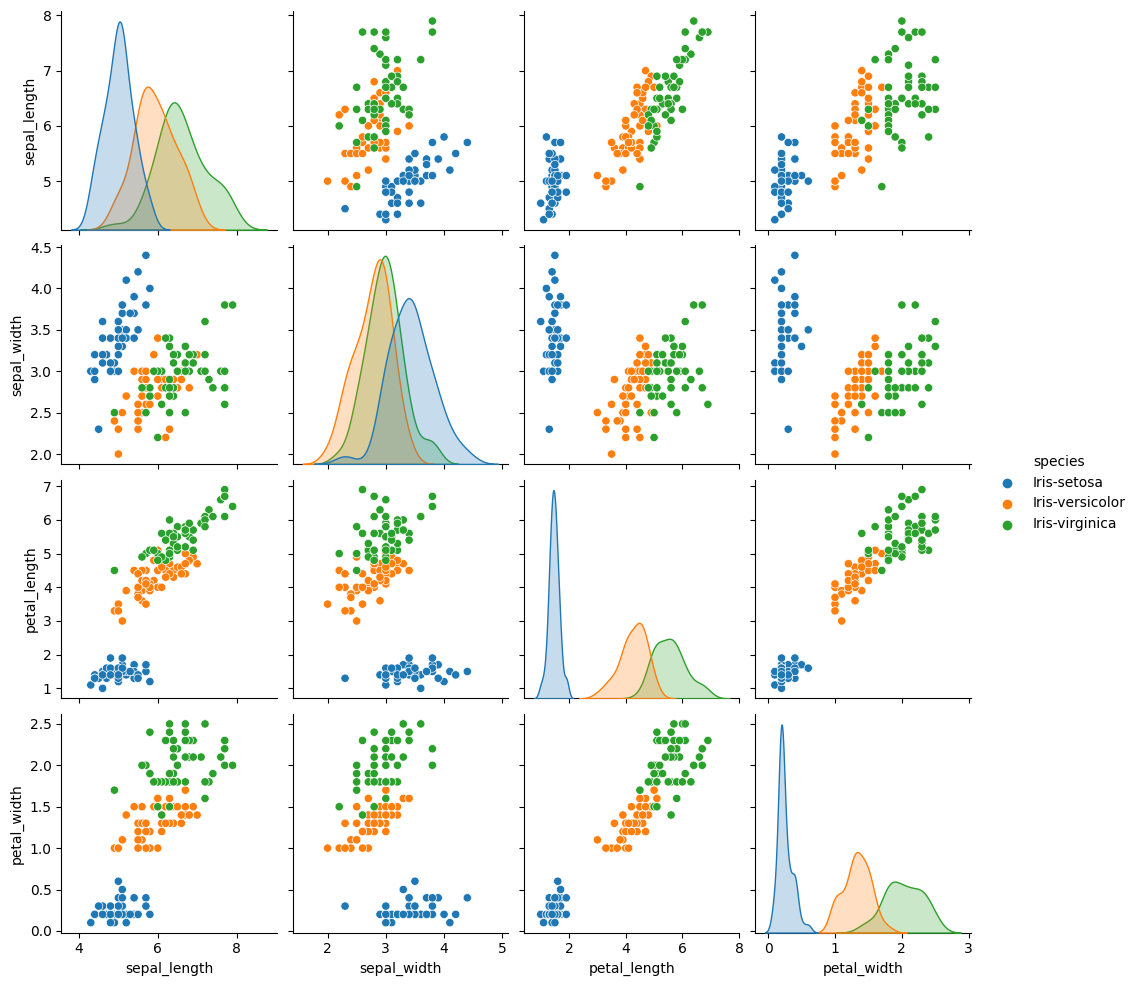

In [10]:
sns.pairplot(data, hue="species");

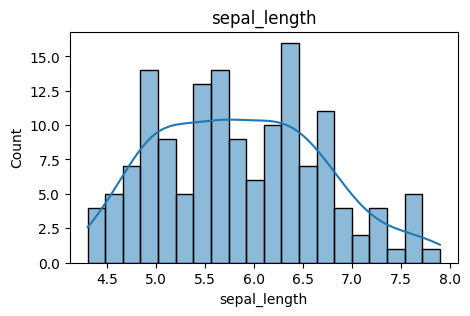

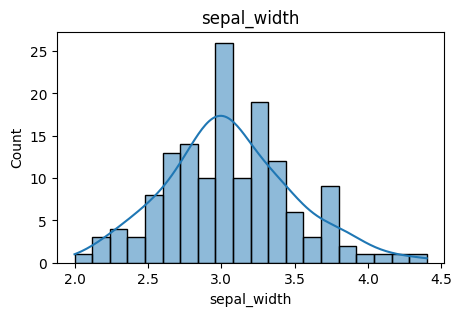

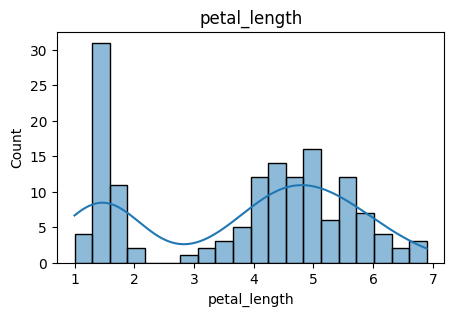

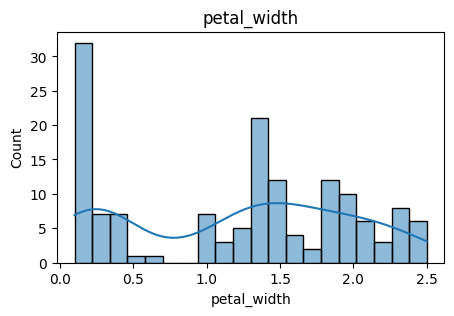

In [11]:
# check numerical distributions
numerical = data.select_dtypes(include="number").columns.to_list()

for num in numerical:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=data[num], kde=True, bins=20)
    plt.title(num)
    plt.show()

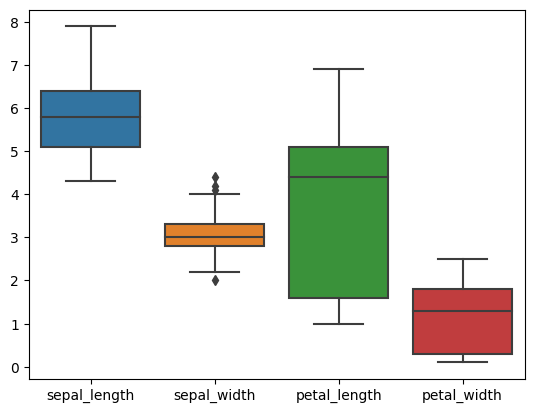

In [12]:
sns.boxplot(data=data[numerical]);

## Preprocessing

In [13]:
# select target and features
X = data[numerical]
y = data["species"]

# split data for training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# scale the numerical features
num_transformer = make_column_transformer(
    (StandardScaler(), ["sepal_length"]),
    (RobustScaler(), ["sepal_width", "petal_length", "petal_width"])
)

#### Logistic Regression Model

In [15]:
# logistic regression model for one-vs-rest multi classification strategy
log_model = LogisticRegression(max_iter=1000, random_state=42)

# make pipeline for reproduceability
pipe_log = make_pipeline(num_transformer, log_model)
pipe_log

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('robustscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Decision Tree Model

In [16]:
# decision tree model for multi classification strategy
tree_model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=3, random_state=42)

# make pipeline for reproduceability
pipe_tree = make_pipeline(num_transformer, tree_model)
pipe_tree

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('robustscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Performance Metrics

In [17]:
# StratifiedKFold for safer balanced split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
%%time

# get baseline score for Logistic Regression
cv_score = cross_val_score(estimator=pipe_log, X=X_train, y=y_train,
                           cv=cv, scoring="accuracy", n_jobs=-1)
cv_score.mean().round(3)

CPU times: user 28 ms, sys: 67.9 ms, total: 95.8 ms
Wall time: 1.05 s


0.932

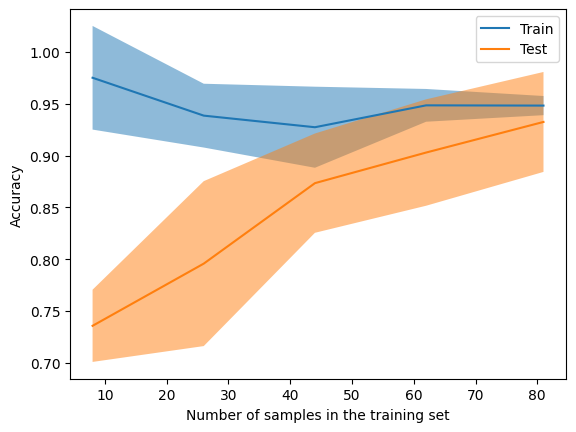

In [19]:
LearningCurveDisplay.from_estimator(estimator=pipe_log,
                                    X=X_train, y=y_train,
                                    cv=cv, scoring="accuracy", n_jobs=-1)

In [20]:
%%time

# get baseline score for Decision Tree
cv_score = cross_val_score(estimator=pipe_tree, X=X_train, y=y_train,
                           cv=cv, scoring="accuracy", n_jobs=-1)
cv_score.mean().round(3)

CPU times: user 613 ms, sys: 366 ms, total: 979 ms
Wall time: 137 ms


0.931

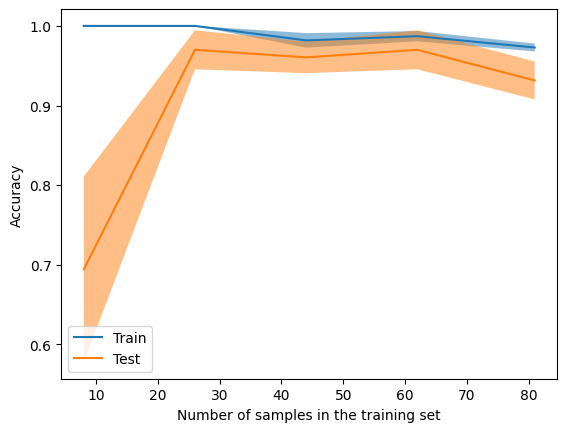

In [21]:
LearningCurveDisplay.from_estimator(estimator=pipe_tree,
                                    X=X_train, y=y_train,
                                    cv=cv, scoring="accuracy", n_jobs=-1)

#### ***Logistic Regression model seems more stable and generalize better, we will fine tune this model for prediction.***

## Fine-tuning

In [22]:
model = LogisticRegression()
final_preproc = make_pipeline(num_transformer, model)

params = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet'],
          "logisticregression__C": [1, 2, 3, 4, 5],
          "logisticregression__solver": ['lbfgs', 'newton-cg', 'sag', 'saga'],
          "logisticregression__multi_class": ['auto', 'ovr', 'multinomial'],
          "logisticregression__max_iter": [100, 500, 1000]}

search = GridSearchCV(estimator=final_preproc, param_grid=params, cv=cv, scoring="accuracy", n_jobs=-1)
search.fit(X_train, y_train)

/Users/till/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/till/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/till/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/till/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class

,estimator,Pipeline(step...egression())])
,param_grid,"{'logisticregression__C': [1, 2, ...], 'logisticregression__max_iter': [100, 500, ...], 'logisticregression__multi_class': ['auto', 'ovr', ...], 'logisticregression__penalty': ['l1', 'l2', ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('standardscaler', ...), ('robustscaler', ...)]"


In [23]:
search.best_params_, search.best_score_.round(3)

({'logisticregression__C': 4,
  'logisticregression__max_iter': 500,
  'logisticregression__multi_class': 'auto',
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'saga'},
 0.951)

#### ***Score has improved from 0.932 to 0.951. We could fine-tune more but we'll use this for now.***

In [24]:
# create final pipeline based on the best estimator from grid search
final_pipe = search.best_estimator_
final_pipe

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('robustscaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Prediction & Metrics

In [25]:
prediction = final_pipe.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, prediction):.2f}")

Accuracy: 0.98


In [26]:
print(classification_report(y_test, prediction))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       1.00      0.92      0.96        12
 Iris-virginica       0.94      1.00      0.97        16

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



### ***Final accuracy score is 0.98, we can conclude that this model has high accuracy.***

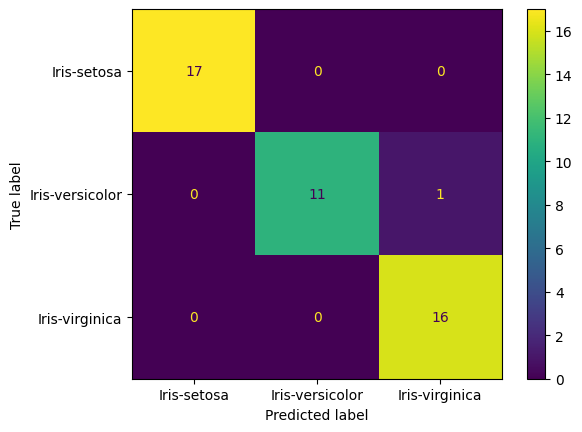

In [ ]:
# confusion matrix to look at where predictions are correct/incorrect
ConfusionMatrixDisplay.from_predictions(y_test, prediction)

# save confusion matrix
plt.savefig("reports/confusion_matrix.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>